<a href="https://colab.research.google.com/github/jujhaar2409/unClear/blob/master/final/UnClear_ESRGAN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload() 
!pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [4]:
!kaggle datasets download -d joe1995/div2k-dataset

100% 3.70G/3.71G [01:40<00:00, 78.5MB/s]
100% 3.71G/3.71G [01:40<00:00, 39.4MB/s]


In [5]:
!unzip "/content/div2k-dataset.zip"

Archive:  /content/div2k-dataset.zip
  inflating: DIV2K_train_HR/DIV2K_train_HR/0001.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0002.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0003.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0004.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0005.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0006.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0007.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0008.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0009.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0010.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0011.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0012.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0013.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0014.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0015.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0016.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0017.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/00

# Pre-processing data



In [16]:
import os
import numpy as np
import cv2

PATH = '/content/DIV2K_train_HR/DIV2K_train_HR'

def random_crop_rotate(input_image):
    start_height = np.random.randint(0,input_image.shape[0]-96)
    start_width = np.random.randint(0,input_image.shape[1]-96)
    image = input_image[start_height:start_height+96 , start_width:start_width+96]
    rot_options = [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180, 0]
    rot_option = rot_options[np.random.randint(0, 4)]
    if rot_option != 0:
        image = cv2.rotate(image, rot_option)
    return image

def load_hr(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image)
    image = np.asarray(image)
    # image = cv2.resize(image, (192, 192))
    hr_image = random_crop_rotate(image)
    return hr_image

def load_lr(hr_image):
    lr_image = cv2.resize(hr_image, (24, 24))
    return lr_image

def normalize(image):
    image_t = tf.convert_to_tensor(image , dtype = tf.float32)
    image_t = image_t / 127.5 -1
    return image_t


train_dataset = os.listdir(PATH)
for i in range(len(train_dataset)):
  train_dataset[i] = PATH + '/' +train_dataset[i]
train_hr_dataset = list(map(load_hr, train_dataset * 4))
train_lr_dataset = list(map(load_lr, train_hr_dataset))
train_hr_dataset = tf.convert_to_tensor(list(map(normalize, train_hr_dataset)))
train_lr_dataset = tf.convert_to_tensor(list(map(normalize, train_lr_dataset)))

# The Generator

In [23]:
from keras.layers import Add, Concatenate, LeakyReLU, Conv2D, Lambda, UpSampling2D

# def dense_block(inpt):
#     b1 = Conv2D(64, kernel_size=3, strides=1, padding='same')(inpt)
#     b1 = LeakyReLU(0.2)(b1)
#     b1 = Concatenate()([inpt,b1])
#     b2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(b1)
#     b2 = LeakyReLU(0.2)(b2)
#     b2 = Concatenate()([inpt,b1,b2]) 
#     b3 = Conv2D(64, kernel_size=3, strides=1, padding='same')(b2)
#     b3 = LeakyReLU(0.2)(b3)
#     b3 = Concatenate()([inpt,b1,b2,b3])
#     b4 = Conv2D(64, kernel_size=3, strides=1, padding='same')(b3)
#     b4 = LeakyReLU(0.2)(b4)
#     b4 = Concatenate()([inpt,b1,b2,b3,b4])
#     b5 = Conv2D(64, kernel_size=3, strides=1, padding='same')(b4)
#     b5 = Lambda(lambda x:x*0.2)(b5)
#     b5 = Add()([b5, inpt])
    
#     return b5
# def RRDB(inpt):
#     x = dense_block(inpt)
#     x = dense_block(x)
#     x = dense_block(x)
#     x = Lambda(lambda x:x*0.2)(x)
#     out = Add()([x,inpt])
#     return out

# def build_generator():
#   inpt = tf.keras.Input(shape = [24,24,3])
#   up = UpSampling2D(4)(inpt)
#   conv1 = Conv2D(64, kernel_size = 3, strides = 1, padding = 'same')(up)
#   rrdb = RRDB(conv1)
#   conv = Conv2D(filters=256, kernel_size=3, strides=1, padding = 'same',activation = 'relu')(rrdb)
#   out = Conv2D(3, kernel_size=3, strides=1, padding = 'same')(conv)
#   return tf.keras.Model(inputs = inpt , outputs = out)

#---------------------------------

# def dense_block(inpt):
#     conv_leaky_1 = Conv2D(64, kernel_size=3, strides=1, padding='same')(inpt)
#     conv_leaky_1 = LeakyReLU(0.2)(conv_leaky_1)
#     conv_leaky_1 = Concatenate()([inpt, conv_leaky_1])
#     conv_leaky_2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(conv_leaky_1)
#     conv_leaky_2 = LeakyReLU(0.2)(conv_leaky_2)
#     conv_leaky_2 = Concatenate()([inpt, conv_leaky_1, conv_leaky_2]) 
#     # conv_leaky_3 = Conv2D(64, kernel_size=3, strides=1, padding='same')(conv_leaky_2)
#     # conv_leaky_3 = LeakyReLU(0.2)(conv_leaky_3)
#     # conv_leaky_3 = Concatenate()([inpt, conv_leaky_1, conv_leaky_2, conv_leaky_3])
#     # conv_final = Conv2D(64, kernel_size=3, strides=1, padding='same')(conv_leaky_3)
#     conv_final = Conv2D(64, kernel_size=3, strides=1, padding='same')(conv_leaky_2)
#     # conv_final = Lambda(lambda x:x*0.2)(conv_final)
#     conv_final = conv_final * 0.2
#     conv_final = Add()([conv_final, inpt])
#     return conv_final

# def RRDB(inpt):
#     x = dense_block(inpt)
#     # x = dense_block(x)
#     x = dense_block(x)
#     # x = Lambda(lambda x:x*0.2)(x)
#     x = x * 0.2
#     out = Add()([x,inpt])
#     return out

# def buildGenerator():
#     inpt = tf.keras.Input(shape = [24, 24, 3])
#     up = UpSampling2D(4)(inpt)
#     conv1 =Conv2D(64, kernel_size = 3, strides = 1, padding = 'same')(up)
#     rrdb = RRDB(conv1)
#     conv = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same',activation = 'relu')(rrdb)
#     out = Conv2D(3, kernel_size= 3, strides = 1, padding = 'same')(conv)
#     return tf.keras.Model(inputs = inpt, outputs = out)

#----------------------------------------------------------------

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, PReLU, Add, Lambda
from tensorflow.keras.models import Model


def dense_block(input_tensor, filters, scale=0.2):
    x_1 = input_tensor

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = LeakyReLU(alpha=0.2)(x)
    x = x_2 = Add()([x_1, x])

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = x_3 = Add()([x_1, x_2, x])

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Add()([x_1, x_2, x_3, x])

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Add()([x_1, x_2, x_3, x])

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = Lambda(lambda x: x * scale)(x)
    x = Add()([x_1, x])

    return x


def sub_pixel_conv2d(scale=2, **kwargs):
    return Lambda(lambda x: tf.nn.depth_to_space(x, scale), **kwargs)


def upsample(input_tensor, filters):
    x = Conv2D(filters=filters*4, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = sub_pixel_conv2d(scale=4)(x)
    x = PReLU(shared_axes=[1, 2])(x)
    return x


def build_generator(filters=64, n_dense_block=4, n_sub_block=1):
    inputs = Input(shape=[24, 24, 3])

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(inputs)
    x = x_1 = LeakyReLU(alpha=0.2)(x)

    for _ in range(n_dense_block):
        x = dense_block(x, filters=filters)

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = Lambda(lambda x: x * 0.2)(x)
    x = Add()([x_1, x])

    # x = UpSampling2D(4)(x)
    for _ in range(n_sub_block):
        x = upsample(x, filters)

    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=3, kernel_size=3, strides=1, padding='same')(x)

    return Model(inputs=inputs, outputs=x)

In [24]:
generator = build_generator()
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 24, 24, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 24, 24, 64)   1792        input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_14 (LeakyReLU)      (None, 24, 24, 64)   0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 24, 24, 64)   36928       leaky_re_lu_14[0][0]             
____________________________________________________________________________________________

# The Discriminator

In [9]:
from keras import backend as K
def build_discriminator():
    leakyrelu_alpha = 0.2
    momentum = 0.8

    input_0 = tf.keras.layers.Input(shape=(24,24,3))
    input_0_upscale = UpSampling2D(4)(input_0)

    input_1 = tf.keras.layers.Input(shape=(96,96,3))
    input_2 = tf.keras.layers.Input(shape = (96,96,3))

    x = tf.keras.layers.concatenate([input_0_upscale,input_1])
    y = tf.keras.layers.concatenate([input_0_upscale,input_2])
    for i in range(4):
      x = Conv2D(64, kernel_size = 3, strides = 1, padding = 'same')(x)
      y = Conv2D(64, kernel_size = 3, strides = 1, padding = 'same')(y)
      x = LeakyReLU()(x)
      y = LeakyReLU()(y)
      x = tf.keras.layers.BatchNormalization()(x)
      y = tf.keras.layers.BatchNormalization()(y)

    logits = x-K.mean(y)
    # fully connected layer 
    output = Conv2D(3,3, activation='sigmoid' , padding = 'same')(logits)   
    
    model = tf.keras.Model(inputs=[input_0, input_1, input_2], outputs=[output], name='discriminator')
    
    return model

In [10]:
discriminator = build_discriminator()
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 24, 3)]  0                                            
__________________________________________________________________________________________________
tf.image.resize_1 (TFOpLambda)  (None, 96, 96, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
______________________________________________________________________________________

# Combining the parts

In [29]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

vgg_model = VGG19(include_top = False, input_shape=(96,96,3))

lam = 150
eta = 150

def train_step(input_lr_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_lr_image, training=True)

        real_logits  = discriminator([input_lr_image, target , gen_output], training=True)
        fake_logits  = discriminator([input_lr_image, target , gen_output], training=True)
        gen_loss     = lam * (K.mean(K.binary_crossentropy(K.zeros_like(real_logits), real_logits) + K.binary_crossentropy(K.ones_like(fake_logits), fake_logits)))
        gen_loss    += eta * tf.reduce_mean(tf.abs(target - gen_output))
        feature_gen  = vgg_model(preprocess_input(gen_output))
        feature_real = vgg_model(preprocess_input(np.copy(target)))
        vgg_loss     = tf.keras.losses.mean_squared_error(feature_gen , feature_real)
        gen_loss    += 150 * vgg_loss
        # gen_loss   = 100 * vgg_loss
        disc_loss = K.mean(K.binary_crossentropy(K.zeros_like(fake_logits), fake_logits) + K.binary_crossentropy(K.ones_like(real_logits), real_logits))

    generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

Epoch 1
.........10.........20.........30.........40.........50.........60.........70.........
.........90.........100.........110.........120.........130.........140.........150.........
.........170.........180.........190.........

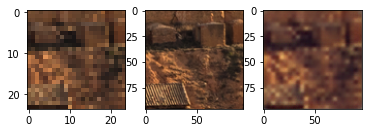

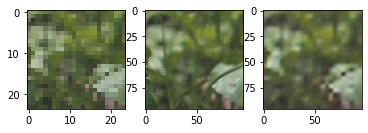

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


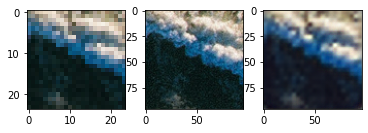

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


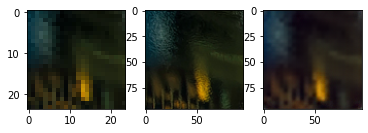

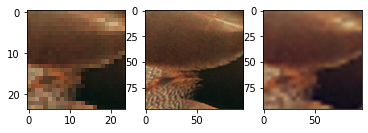

Epoch 1 took 58.284952878952026 sec

Epoch 2
.........10.........20.........30.........40.........50.........60.........70.........
.........90.........100.........110.........120.........130.........140.........150.........
.........170.........180.........190.........

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


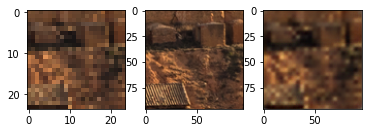

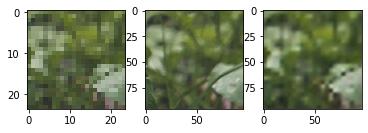

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


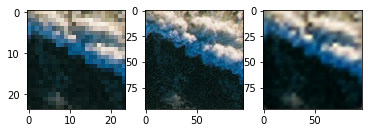

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


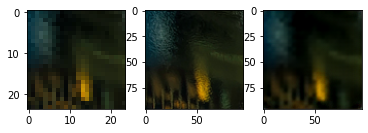

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


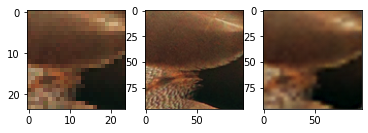

Epoch 2 took 58.09908699989319 sec



In [30]:
import time 

BATCH_SIZE = 16
EPOCHS = 2
 
def fit(train_lr, train_hr, epochs):
    for epoch in range(epochs):
        start = time.time()
        print(f"Epoch {epoch + 1}", end="")
        for i in range(len(train_hr) // BATCH_SIZE):
            if i % 10 != 0:
                print(".", end="")
            elif i % 80 == 0:
                print()
            elif i % 10 == 0:
                print(i, end="")
            input_image  = train_lr[BATCH_SIZE * i : BATCH_SIZE * i + BATCH_SIZE]
            target  =  train_hr[BATCH_SIZE * i : BATCH_SIZE * i + BATCH_SIZE]
            train_step(input_image, target, epoch)

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        generated = generator(train_lr_dataset[0:5])
        for i in range(len(generated)):
            plt.subplot(1,3,1)
            plt.imshow(train_lr_dataset[i]/2+0.5)
            plt.subplot(1,3,2)
            plt.imshow(train_hr_dataset[i]/2+0.5)
            plt.subplot(1,3,3)
            # print(train_hr_dataset[i])
            plt.imshow(generated[i] / 2 + 0.5)
            # print(generated[i])
            plt.show()
        print ('Epoch {} took {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

# checkpoint_dir = '/content/drive/Shareddrives/main/kaggle/ESRGAN-chkpts'
# checkpoint_prefix = os.path.join(checkpoint_dir, "checkpoint")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

fit(train_lr_dataset, train_hr_dataset, EPOCHS)

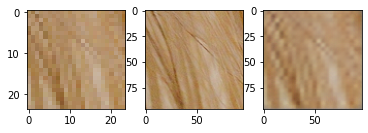

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


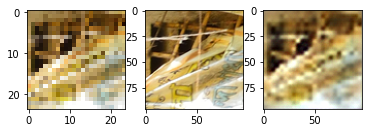

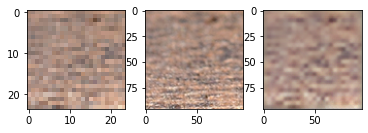

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


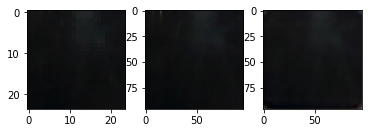

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


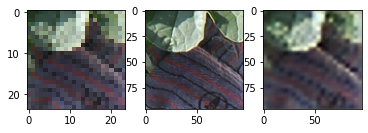

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


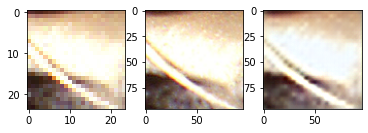

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


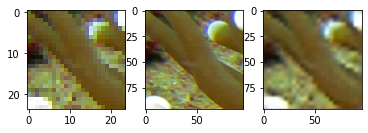

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


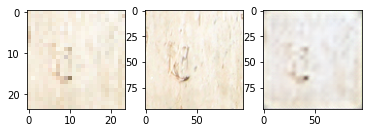

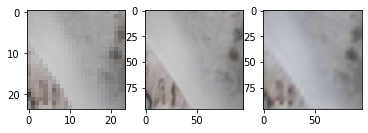

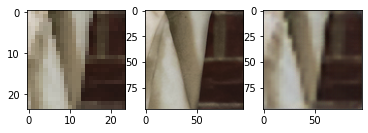

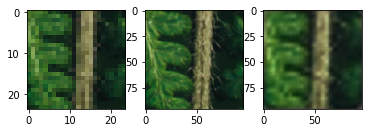

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


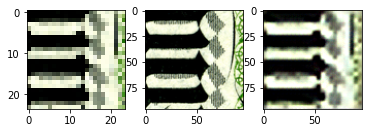

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


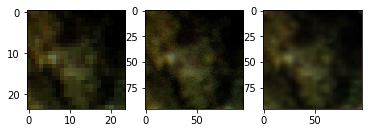

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


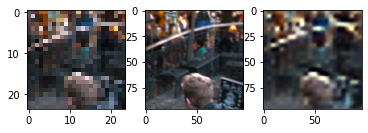

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


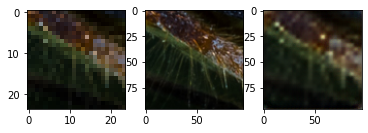

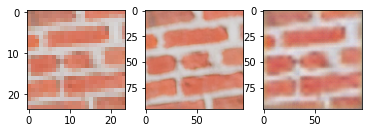

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


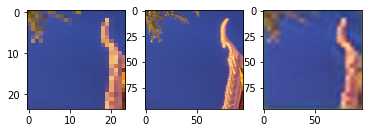

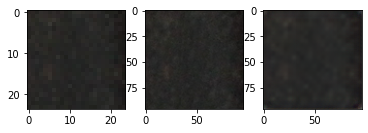

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


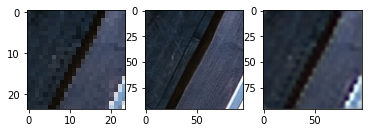

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


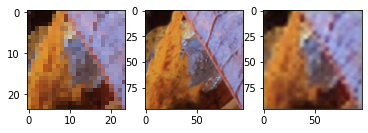

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


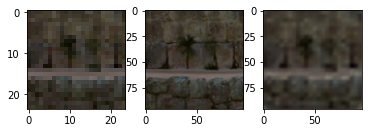

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


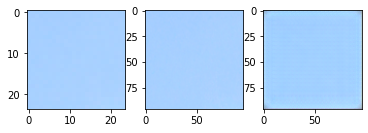

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


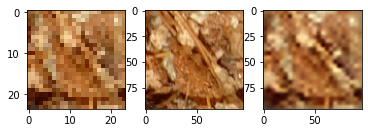

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


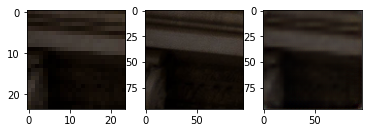

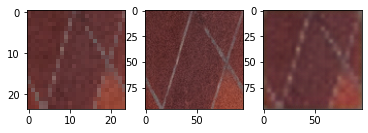

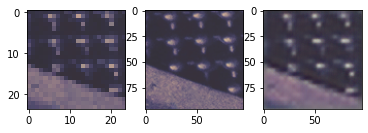

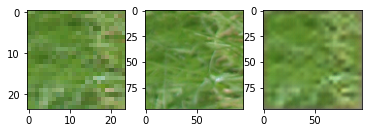

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


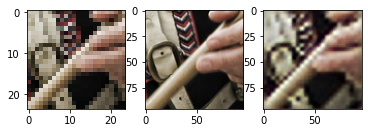

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


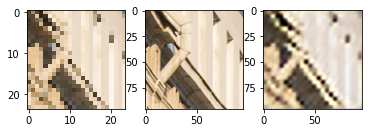

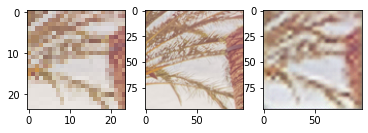

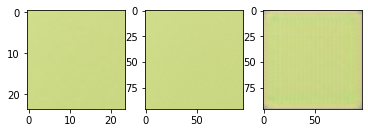

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


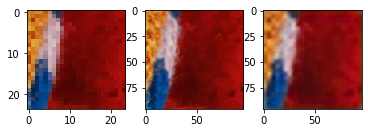

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


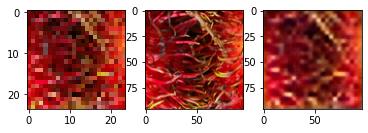

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


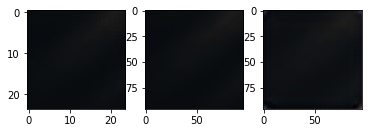

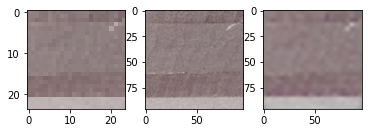

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


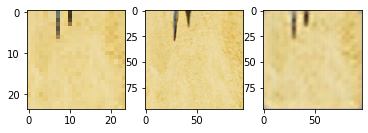

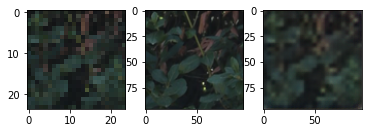

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


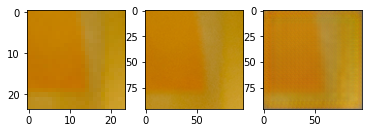

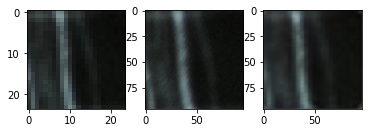

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


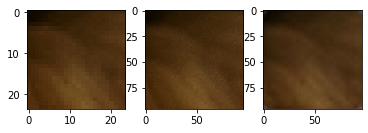

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


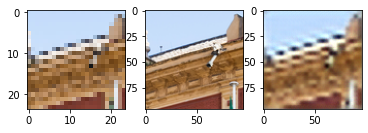

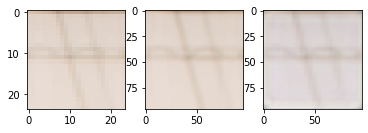

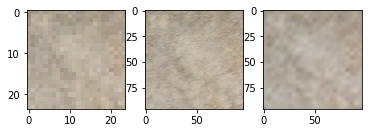

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


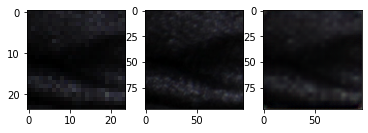

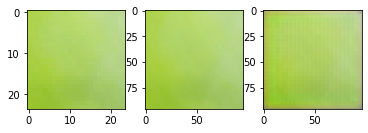

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


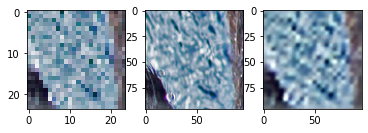

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


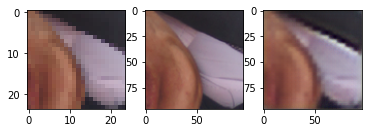

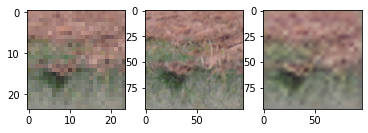

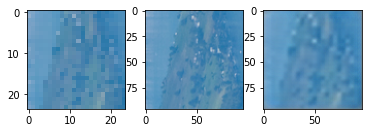

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


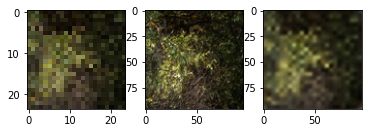

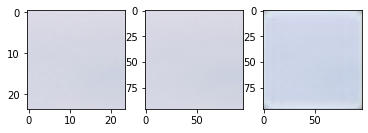

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


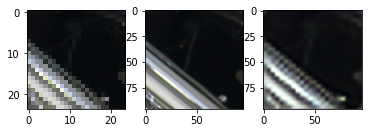

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


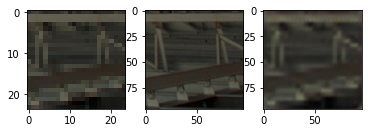

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


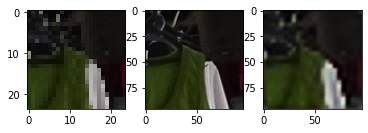

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


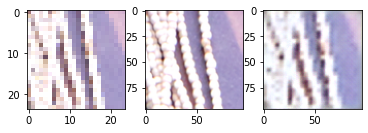

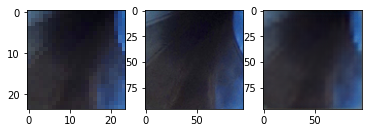

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


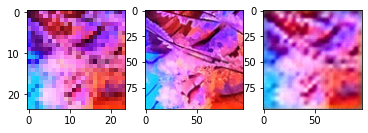

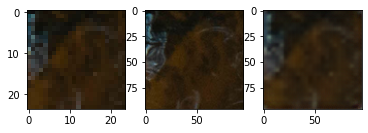

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


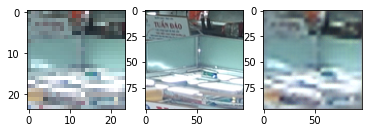

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


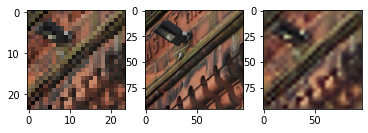

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


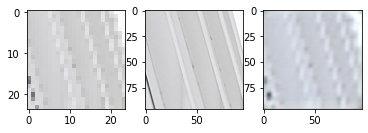

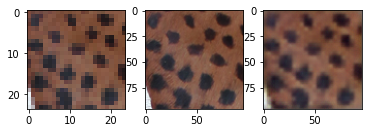

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


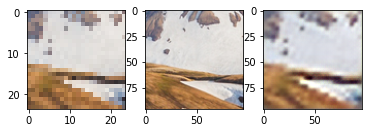

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


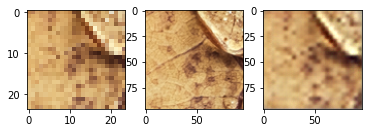

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


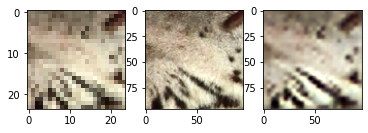

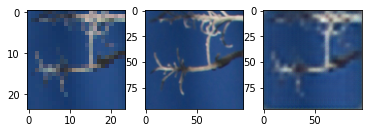

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


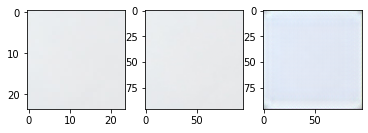

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


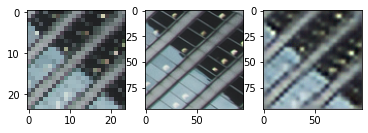

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


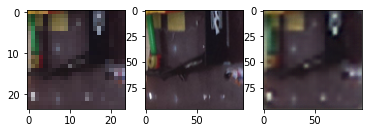

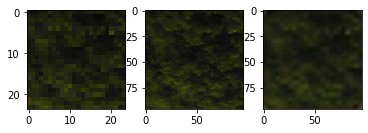

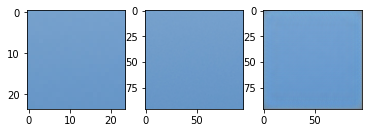

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


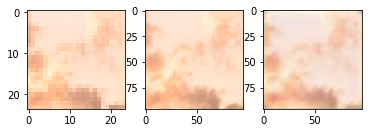

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


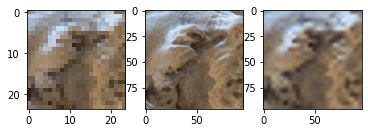

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


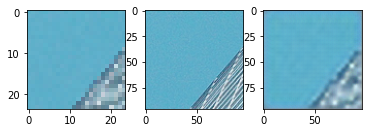

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


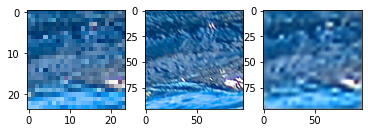

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


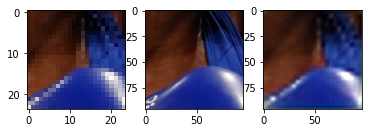

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


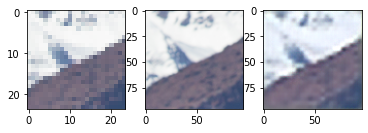

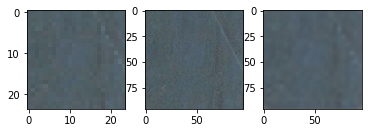

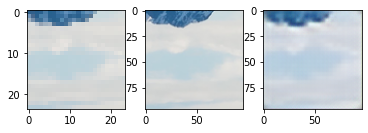

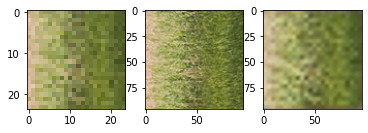

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


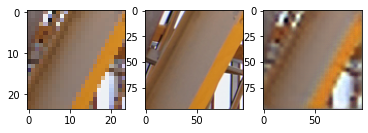

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


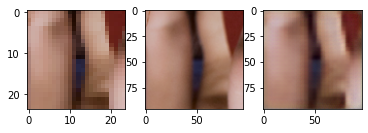

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


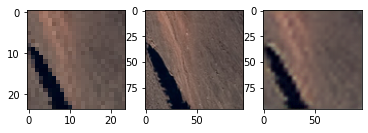

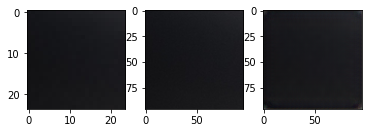

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


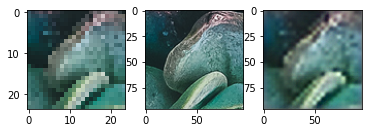

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


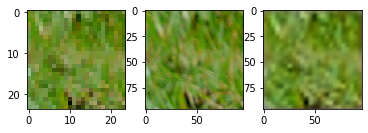

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


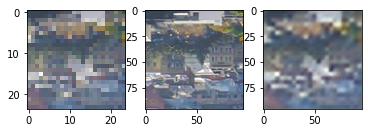

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


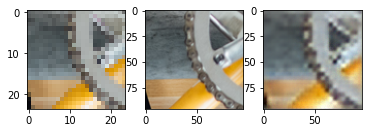

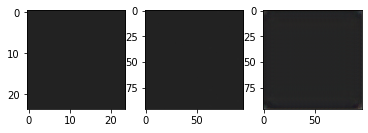

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


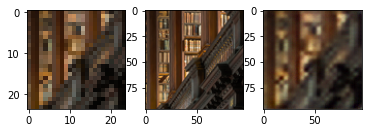

In [27]:
import random, os
import matplotlib.pyplot as plt

# checkpoint_dir = '/content/drive/Shareddrives/main/kaggle/ESRGAN-chkpts'
# checkpoint_prefix = os.path.join(checkpoint_dir, "checkpoint")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

index = 70
for i in range(index, index + 10):
    generated = generator(train_lr_dataset[10*i:10*i+10])
    for j in range(9):
        plt.subplot(1,3,1)
        plt.imshow(train_lr_dataset[j+10*i]/2+0.5)
        plt.subplot(1,3,2)
        plt.imshow(train_hr_dataset[j+10*i]/2+0.5)
        plt.subplot(1,3,3)
        plt.imshow(generated[j]/2 + 0.5)
        plt.show()

In [14]:
checkpoint.save(file_prefix = checkpoint_prefix)

'/content/drive/Shareddrives/main/kaggle/ESRGAN-chkpts/checkpoint-16'